# Run NetConf on Houston IEEE data

In [1]:
# Import helper functions
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import imports as ip
import netconf as nc
import plotting as pl
import helper_functions as hf

In [2]:
# Data files
labelFile = './data/2018IEEE_Contest/Phase2/TrainingGT/2018_IEEE_GRSS_DFC_GT_TR.tif' # Ground Truth
hsFile = './data/2018IEEE_Contest/Phase2/FullHSIDataset/20170218_UH_CASI_S4_NAD83.pix' # Hyperspectral file
radarFile = './data/2018IEEE_Contest/Phase2/Lidar GeoTiff Rasters/Intensity_C3/UH17_GI3F051.tif' # LiDAR file
skip = 20 # Downsample by using every nth sample
crs = 'EPSG:6577' # Coordinate system

# A priori class beliefs
nClasses, cn = 2, 'class' # Number of classes (Houston default: 20), name of classes
confidence = [0, 1] # Confidence in a priori labels (other classes, specified class)

# Pre-processing 
pca, comp  = True, 4 # Hyperspectral data PCA, component number
cluster = 'mean' # Clustering type if nClasses < nLabels ('all' samples used or 'mean' of label class used)

# Edge creation
adjacent, geoNeighbours, phase, neighbours = False, 2, True, [3,2] # geographical edges, n neighbours, data value edges, n neighbours for each data type

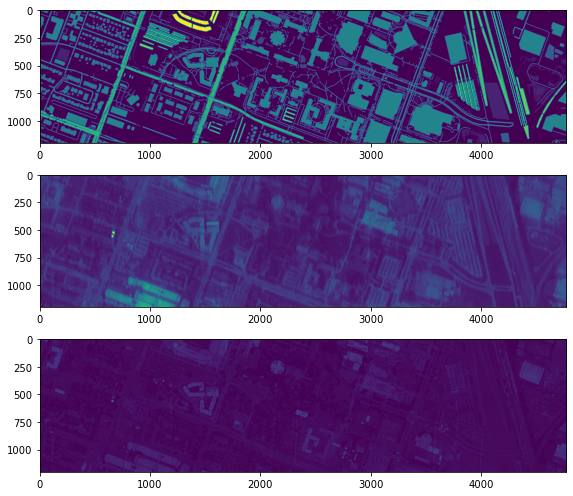

In [3]:
# Import ground truth
labels, larr = ip.raster_to_df(labelFile)

# Import aerial data
hs, hsarr = ip.raster_to_df(hsFile, value='amp', multidims=True, crop=True)
radar, radararr = ip.raster_to_df(radarFile, value='phase', crop=True)
processed = False

# Plot rasters for each data type
fig, axs = pl.create_subplots(3,1,[10,7])
axs[0].imshow(larr[0])
axs[1].imshow(hsarr[0])
axs[2].imshow(radararr[0])
fig.tight_layout()

In [5]:
# Pre-process data
if not processed: 
    rm = labels[cn] != 0 # Remove unclassified data
    labels, hs, radar = labels[rm][::skip], hs[rm][::skip], radar[rm][::skip] # Downsample data to run BP
    processed = True

# K-Means Clustering if nClasses < nLabels
if nClasses < len(labels[cn].unique()):
    # Run PCA on hyperspectral data
    X = hf.run_PCA(hs.values.transpose(), comp).components_.transpose() if pca else hs
    # Clustering
    kmeans, clusterClasses,_ = hf.run_cluster(X, labels, cluster, nClasses)
    print(clusterClasses)
else: clusterClasses = hf.default_classes(labels[cn])

[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
# Filter values for hyperspectral classes
takeClasses = True
if takeClasses: 
    classesUsed, labelsCl, hsCl, radarCl = [], labels, hs, radar
    for j in range(nClasses): classesUsed.append([i+1 for i, x in enumerate(list(clusterClasses)) if x==j])
else:
    classesUsed = [[3,20],[6,15]]
    used = [i in [3,20,6,15] for i in labels.values]
    labelsCl, hsCl, radarCl = labels[used], hs[used], radar[used]

# Get geodatabase of every pixel and assign beliefs
initial = hf.init_beliefs(hf.concat_dfs([hsCl,radarCl]), classes=nClasses, crs=crs)

# Assign labels for each pixel
geoLabels = hf.df_to_gdf(labelsCl, columns=[cn], crs=crs, reIndex=True)
geoLabels[cn] = hf.group_classes(geoLabels[cn], classesUsed)

# Split pixels in to train and test sets
X_train, X_test, y_train, y_test = hf.train_test_split(geoLabels, column = cn)

# Create nodes for belief propagation from pixels, assigning priors to train set
nodes = hf.create_nodes(initial, X_train)

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, beliefColumns = initial.columns[-nClasses-1:-1], beliefs=confidence)

# Create edges dependent on geographical and/or hyperspectral and lidar proximity
edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbors=geoNeighbours, values=[nodes.columns[:50], ['phase']] if phase else False, neighbours=neighbours)

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [7]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True,limit=1e-3)

Nodes: 100946, Edges: 15343792


MemoryError: Unable to allocate 185. TiB for an array with shape (5047300, 5047300) and data type float64

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30256
         1.0       0.00      0.00      0.00        18
         2.0       0.00      0.00      0.00        10

    accuracy                           1.00     30284
   macro avg       0.33      0.33      0.33     30284
weighted avg       1.00      1.00      1.00     30284



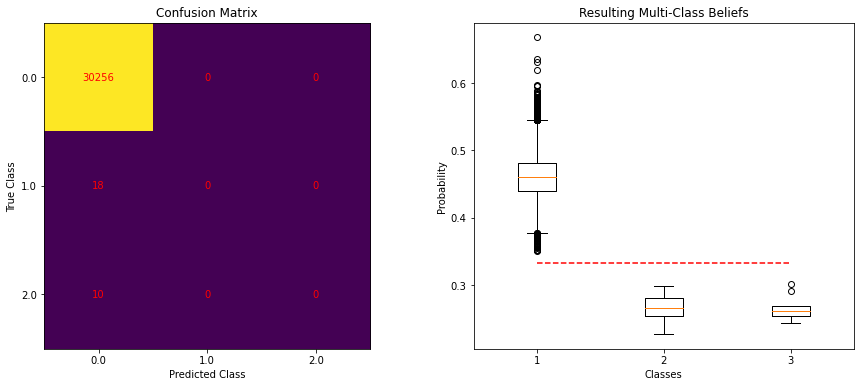

In [8]:
# Evaluation Metrics
# Get y_true vs y_pred for test set
y_true, y_pred = hf.get_labels(initial, X_test, beliefs, column=cn)

# Classification metrics
yp_clf, classes = hf.class_metrics(y_true, y_pred)

# Visualisations
fig, axs = pl.create_subplots(1,2, figsize=[15,6])
# Confusion matrix
axs = pl.confusion_matrix(axs, y_true, yp_clf, classes)
# Cross entropy / Confidence metrics
if nClasses == 2: axs = pl.cross_entropy_metrics(axs, y_true, y_pred, classes)
else: axs[1] = pl.cross_entropy_multiclass(axs[1], y_true, y_pred)
pl.show_plot()

In [23]:
# Save figure
pl.save_plot(fig, 'results/Houston_adj{}{}_ps{}{}_cl{}{}'.format(str(adjacent),str(geoNeighbours),str(phase),str(neighbours),str(takeClasses),str(nClasses)))#,str(pca),str(comp),cluster))